In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import os
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from src.utils import get_network
from src.datasets import AudioMNISTDataset

# Functions

In [3]:
def plot_embeddings_by_label(embeddings_2d, labels, synth_embeddings_2d=None, synth_labels=None, 
                             label_names=None, title="t-SNE visualization of embeddings", 
                             figsize=(8, 8), alpha=0.6, colormap='viridis'):
    """
    Plot 2D embeddings with different colors for each label class and a proper legend.
    Additionally, plot synthetic embeddings as stars with the same color as their corresponding labels.
    
    Args:
        embeddings_2d: Numpy array of shape (n_samples, 2) containing 2D embeddings
        labels: Numpy array of shape (n_samples,) containing genre labels as integers
        synth_embeddings_2d: Numpy array of shape (n_samples, 2) containing 2D synthetic embeddings (optional)
        synth_labels: Numpy array of shape (n_samples,) containing synthetic labels as integers (optional)
        label_names: List of label names corresponding to the integer labels
        title: Title for the plot
        figsize: Size of the figure as (width, height)
        alpha: Transparency of the points
        colormap: Colormap to use for different genres
        
    Returns:
        fig, ax: The figure and axis objects for further customization
    """
    
    # Get unique labels
    unique_labels = np.unique(labels)
    
    # Create a colormap with distinct colors for each genre
    cmap = plt.cm.get_cmap(colormap, len(unique_labels))
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot each genre separately
    for i, genre in enumerate(unique_labels):
        # Mask for original embeddings
        mask = labels == genre
        ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                   color=cmap(i), alpha=alpha, label=label_names[i], marker='o')
        
        # Mask for synthetic embeddings (if provided)
        if synth_embeddings_2d is not None and synth_labels is not None:
            synth_mask = synth_labels == genre
            ax.scatter(synth_embeddings_2d[synth_mask, 0], synth_embeddings_2d[synth_mask, 1], 
                       color=cmap(i), alpha=alpha, marker='*', s = 300, edgecolors= 'black', label=f"Synth {label_names[i]}")
    
    # Add labels and title
    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    return fig, ax

In [4]:
class PrototypeClassifier:
    def __init__(self, prototypes, prototype_labels):
        """
        Initialize the class with prototypes and their corresponding labels.
        
        Args:
            prototypes: Tensor of shape (n_prototypes, embedding_dim) containing synthetic data.
            prototype_labels: Tensor of shape (n_prototypes,) containing labels for each prototype.
        """
        self.prototypes = prototypes
        self.prototype_labels = prototype_labels

    def predict(self, embedding):
        """
        Predict the label for a given embedding based on cosine similarity with prototypes.
        
        Args:
            embedding: Tensor of shape (embedding_dim,) or numpy array representing the input embedding.
        
        Returns:
            predicted_label: The label of the most similar prototype.
        """
        # Convert embedding to PyTorch tensor if it's a numpy array
        if isinstance(embedding, np.ndarray):
            embedding = torch.tensor(embedding, dtype=torch.float32)
        
        # Compute cosine similarity between the embedding and all prototypes
        cosine_similarities = F.cosine_similarity(embedding.unsqueeze(0), self.prototypes)
        
        # Apply softmax to the cosine similarities
        softmax_scores = F.softmax(cosine_similarities, dim=0)
        
        # Find the index of the prototype with the highest similarity
        most_similar_index = torch.argmax(softmax_scores)
        
        # Assign the label of the most similar prototype
        predicted_label = self.prototype_labels[most_similar_index]
        
        return predicted_label, softmax_scores

    def predict_batch(self, embeddings):
        """
        Predict the labels for multiple embeddings based on cosine similarity with prototypes.
        
        Args:
            embeddings: Tensor of shape (n_samples, embedding_dim) or numpy array of embeddings.
        
        Returns:
            predicted_labels: List of predicted labels for each embedding.
        """
        # Convert embeddings to PyTorch tensor if it's a numpy array
        if isinstance(embeddings, np.ndarray):
            embeddings = torch.tensor(embeddings, dtype=torch.float32)
        
        # Compute cosine similarity between each embedding and all prototypes
        cosine_similarities = F.cosine_similarity(embeddings.unsqueeze(1), self.prototypes.unsqueeze(0), dim=2)
        
        # Apply softmax to the cosine similarities
        softmax_scores = F.softmax(cosine_similarities, dim=1)
        
        # Find the indices of the prototypes with the highest similarity for each embedding
        most_similar_indices = torch.argmax(softmax_scores, dim=1)
        
        # Assign the labels of the most similar prototypes
        predicted_labels = self.prototype_labels[most_similar_indices]
        
        return predicted_labels

In [5]:
def plot_confusion_matrix(test_labels, predicted_labels, label_names=None, title="Confusion Matrix", cmap=plt.cm.Blues, figsize=(8, 6)):
    """
    Plot a confusion matrix for the given test and predicted labels.

    Args:
        test_labels: Array-like of shape (n_samples,) containing the true labels.
        predicted_labels: Array-like of shape (n_samples,) containing the predicted labels.
        label_names: Optional; List of label names corresponding to the integer labels.
        title: Title for the confusion matrix plot.
        cmap: Colormap to use for the plot.
        figsize: Tuple specifying the figure size (width, height).

    Returns:
        None
    """
    # Compute confusion matrix
    cm = confusion_matrix(test_labels, predicted_labels, labels=np.unique(test_labels))
    
    # Use label names if provided, otherwise default to unique labels
    display_labels = label_names if label_names is not None else np.unique(test_labels)
    
    # Create a larger figure
    plt.figure(figsize=figsize)
    
    # Create and plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=cmap, ax=plt.gca())  # Use the current axis for the plot
    plt.title(title)
    plt.show()

# Visualizations

In [6]:
net = get_network(model='ConvNet', channel=1, num_classes=10, im_size=(128, 128))

In [7]:
# load result/res_DM_AUDIO_MNIST_ConvNet_1ipc.pt
data = torch.load('result/res_DM_AUDIO_MNIST_ConvNet_10ipc.pt', weights_only=False)
synth_spectrogram = data['data'][0][0]
synth_labels = data['data'][0][1]
synth_spectrogram.shape

torch.Size([100, 1, 128, 128])

In [8]:
synth_embs = net.embed(synth_spectrogram)

In [9]:
synth_embs = np.array(synth_embs.detach().cpu())

In [10]:
dst_train = AudioMNISTDataset(root_dir=os.path.join('data', 'AUDIO_MNIST'), split = 'train')
real_embs = []
real_labels = []
for i, (spectrogram, label) in enumerate(dst_train):
    if i % 1000 == 0:
        print(f"Processing {i}th sample")
        if(i > 10000):
            break
    real_embs.append(net.embed(spectrogram.unsqueeze(0)).detach().cpu().numpy())
    real_labels.append(label)
real_embs = np.concatenate(real_embs, axis=0)
real_labels = np.array(real_labels)

/Users/isabelurregog/.pyenv/versions/3.8/envs/data-condensation/lib/python3.9/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Processing 0th sample
Processing 1000th sample
Processing 2000th sample
Processing 3000th sample
Processing 4000th sample
Processing 5000th sample
Processing 6000th sample
Processing 7000th sample
Processing 8000th sample
Processing 9000th sample
Processing 10000th sample
Processing 11000th sample


In [15]:
dst_test = AudioMNISTDataset(root_dir=os.path.join('data', 'AUDIO_MNIST'), split = 'val')
test_embs = []
test_labels = []
for i, (spectrogram, label) in enumerate(dst_test):
    if i % 1000 == 0:
        print(f"Processing {i}th sample")
        if(i > 10000):
            break
    test_embs.append(net.embed(spectrogram.unsqueeze(0)).detach().cpu().numpy())
    test_labels.append(label)
test_embs = np.concatenate(test_embs, axis=0)
test_labels = np.array(test_labels)

/Users/isabelurregog/.pyenv/versions/3.8/envs/data-condensation/lib/python3.9/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Processing 0th sample
Processing 1000th sample
Processing 2000th sample
Processing 3000th sample
Processing 4000th sample
Processing 5000th sample


In [11]:
tsne = TSNE(n_components=2)
all_embeddings = np.concatenate((real_embs, synth_embs), axis=0) 
# normalize embeddings
all_embeddings = all_embeddings / np.linalg.norm(all_embeddings, axis=1, keepdims=True)
embeddings = all_embeddings[:real_embs.shape[0]]
synth_embeddings = all_embeddings[embeddings.shape[0]:]
all_embeddings_2d = tsne.fit_transform(all_embeddings)

In [12]:
embeddings_2d = all_embeddings_2d[:len(embeddings)]
synth_embeddings_2d = all_embeddings_2d[len(embeddings):]

/var/folders/50/wlyv6sf11b758pq7zg77kk1h0000gn/T/ipykernel_66349/1015683222.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap, len(unique_labels))


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 't-SNE visualization of AUDIO MNIST embeddings with synthetic data'}, xlabel='Dimension 1', ylabel='Dimension 2'>)

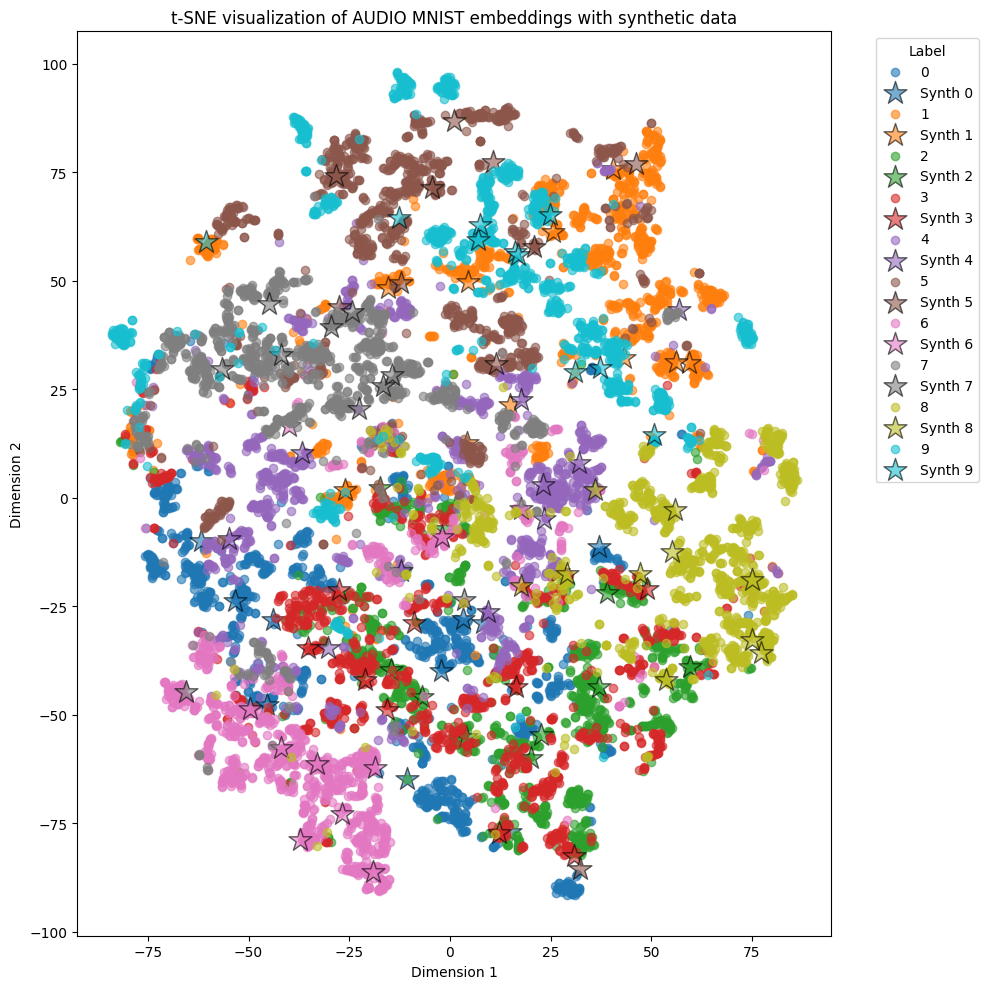

In [13]:
plot_embeddings_by_label(embeddings_2d, real_labels, 
                         synth_embeddings_2d=synth_embeddings_2d, 
                          synth_labels=synth_labels,
                          label_names=[str(i) for i in range(10)],
                          title="t-SNE visualization of AUDIO MNIST embeddings with synthetic data",
                          figsize=(10, 10), alpha=0.6, colormap='tab10')

In [16]:
predictor = PrototypeClassifier(
    prototypes=torch.tensor(synth_embeddings, dtype=torch.float32),
    prototype_labels=torch.tensor(synth_labels, dtype=torch.int64)
)

batch_size = 64
predicted_labels = []
for i in range(0, test_embs.shape[0], batch_size):
    batch_embeddings = torch.tensor(test_embs[i:i + batch_size], dtype=torch.float32)
    predicted_labels_batch = predictor.predict_batch(batch_embeddings)
    predicted_labels.extend(predicted_labels_batch.numpy())
predicted_labels = np.array(predicted_labels)

/var/folders/50/wlyv6sf11b758pq7zg77kk1h0000gn/T/ipykernel_66349/3780551025.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prototype_labels=torch.tensor(synth_labels, dtype=torch.int64)


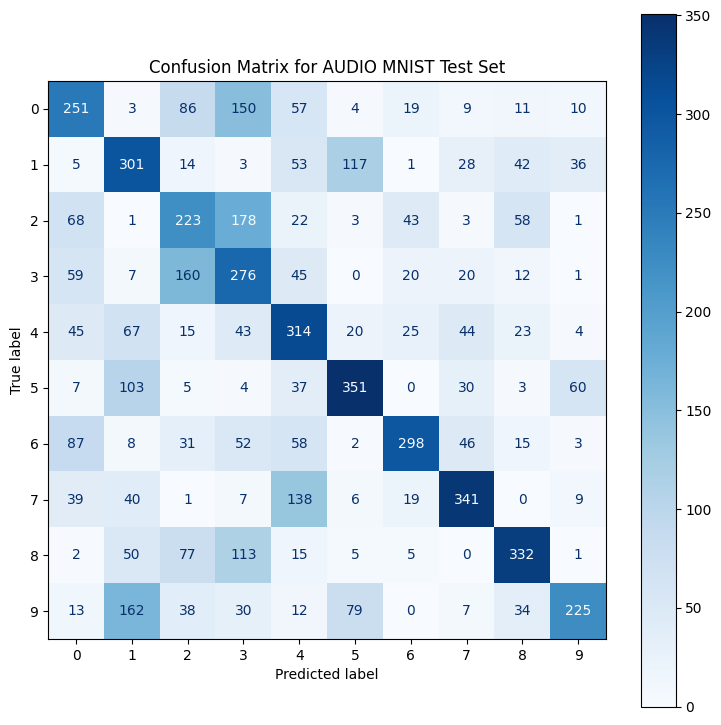

In [18]:
plot_confusion_matrix(test_labels, predicted_labels,
                      label_names=[str(i) for i in range(10)],
                      title="Confusion Matrix for AUDIO MNIST Test Set",
                      cmap=plt.cm.Blues,
                      figsize=(9, 9))

In [19]:
# Accuracy and f1 score
accuracy = accuracy_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

Accuracy: 0.4853, F1 Score: 0.4912


Now we are going to compare the results agains using the means of the clusters as prototypes

In [20]:
# get mean of each label on train set
unique_labels = np.unique(real_labels)
mean_embeddings = np.array([real_embs[real_labels == label].mean(axis=0) for label in unique_labels]) 
mean_embeddings.shape

(10, 32768)

In [21]:
tsne = TSNE(n_components=2)
all_embeddings = np.concatenate((real_embs, mean_embeddings), axis=0) 
# normalize embeddings
all_embeddings = all_embeddings / np.linalg.norm(all_embeddings, axis=1, keepdims=True)
all_embeddings_2d = tsne.fit_transform(all_embeddings)

In [22]:
embeddings_2d = all_embeddings_2d[:len(embeddings)]
synth_embeddings_2d = all_embeddings_2d[len(embeddings):]

/var/folders/50/wlyv6sf11b758pq7zg77kk1h0000gn/T/ipykernel_66349/1015683222.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap, len(unique_labels))


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 't-SNE visualization of AUDIO MNIST embeddings with mean data'}, xlabel='Dimension 1', ylabel='Dimension 2'>)

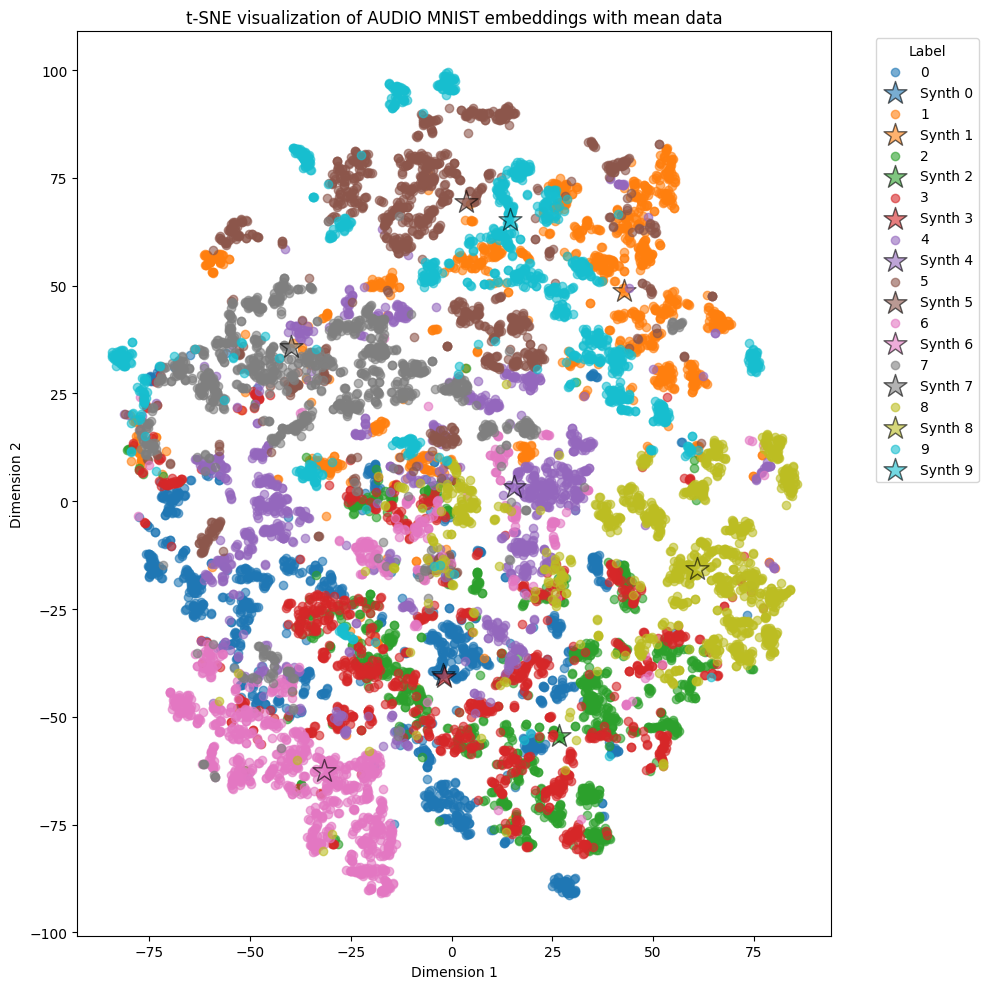

In [23]:
plot_embeddings_by_label(embeddings_2d, real_labels, 
                         synth_embeddings_2d=synth_embeddings_2d, 
                          synth_labels=unique_labels,
                          label_names=[str(i) for i in range(10)],
                          title="t-SNE visualization of AUDIO MNIST embeddings with mean data",
                          figsize=(10, 10), alpha=0.6, colormap='tab10')

In [24]:
predictor = PrototypeClassifier(
    prototypes=torch.tensor(mean_embeddings, dtype=torch.float32),
    prototype_labels=torch.tensor(unique_labels, dtype=torch.int64)
)

predicted_labels = predictor.predict_batch(torch.tensor(test_embs, dtype=torch.float32))

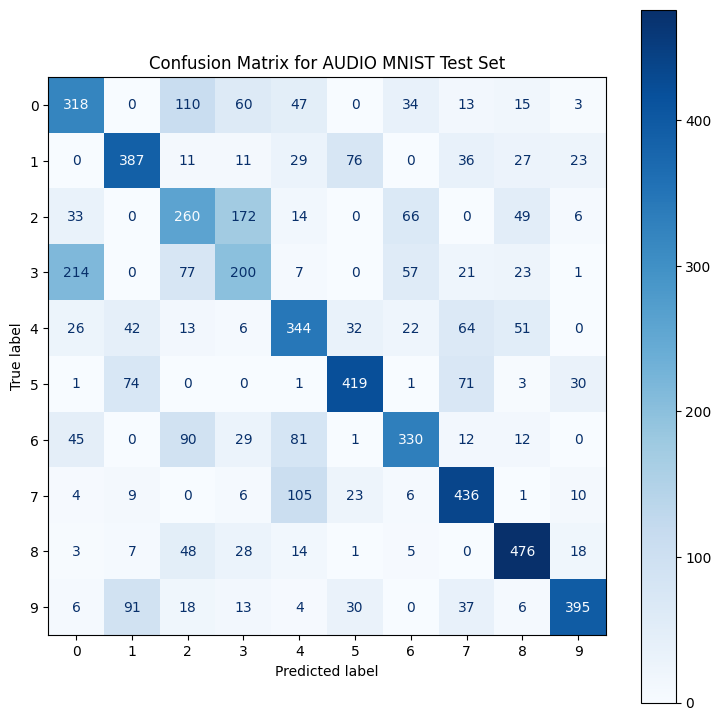

In [25]:
plot_confusion_matrix(test_labels, predicted_labels.numpy(),
                      label_names=[str(i) for i in range(10)],
                      title="Confusion Matrix for AUDIO MNIST Test Set",
                      cmap=plt.cm.Blues,
                      figsize=(9, 9))

In [26]:
# Accuracy and f1 score
accuracy = accuracy_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

Accuracy: 0.5942, F1 Score: 0.5935
